# Imports

In [25]:
!pip install tensorflow
!pip install tensorflow_text

In [26]:
!pip install transformers

In [27]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
#from official.nlp import optimization  # to create AdamW optmizer
import torch
from transformers import BertTokenizer, BertModel, TFBertForSequenceClassification

import codecs
import numpy as np
import seaborn as sns
import pandas as pd
import json as js

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')
from tqdm import tqdm
from collections import Counter
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Opening files & Conversion

## Opening

In [28]:
with open('AskUbuntuCorpus.json') as f:
    askubuntu = js.load(f)

with open('ChatbotCorpus.json') as f:
    chatbot = js.load(f)

with open('WebApplicationsCorpus.json') as f:
    webapps = js.load(f)

## Conversion & split

In [29]:
def create_train_test(ds):
    new_dict = {}
    for k,v in [(key,d[key]) for d in ds['sentences'] for key in d]:
        if k not in new_dict: 
            new_dict[k]=[v]
        else: new_dict[k].append(v)
            
    # remove unnecessary keys   
    
    for a in ['author', 'url', 'entities', 'answer']:
        new_dict.pop(a, '')
        
    new_df = pd.DataFrame(new_dict)
    
    print("Original Labels")
    print("-------------------------")
    labels = new_df.intent
    print(Counter(labels))
    le = LabelEncoder()
    l = le.fit_transform(labels)
    print("\nEncoded Labels")
    print("------------------------")
    print(Counter(l))
    
    new_df['intent'] = l
    
    #### Splitting train and test
    
    train = new_df.loc[new_df['training'] == True].reset_index(drop = True).drop('training', axis=1)
    
    X = train.text
    y = train.intent
    
#     ### Label encoding
#     print("Original Labels Train/Val")
#     print("-------------------------")
#     print(Counter(y))
#     le = LabelEncoder()
#     l = le.fit_transform(y)
#     print("\nEncoded Labels Train/Val")
#     print("------------------------")
#     print(Counter(l))
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
    
    test = new_df.loc[new_df['training'] != True].reset_index(drop = True).drop('training', axis=1)
    
    X_test = test.text
    y_test = test.intent
    
#     ### Label encoding
#     print("\nOriginal Labels Test")
#     print("--------------------")
#     print(Counter(y_test))
#     le = LabelEncoder()
#     y_test = le.fit_transform(y_test)
#     print("\nEncoded Labels Test")
#     print("-------------------")
#     print(Counter(y_test))
    
    #askubuntu_ds = 
    #askubuntu_df = 

    
    return X_train.to_numpy(), X_test.to_numpy(), X_val.to_numpy(), y_train, y_test, y_val

##### askubuntu
print("\nAskUbuntu Labels")
print("----------------\n")
askubuntu_X_train, askubuntu_X_test, askubuntu_X_val, askubuntu_y_train, askubuntu_y_test, askubuntu_y_val = create_train_test(askubuntu)

##### chatbot
print("\n----------------\n")
print("\nChatbot Labels")
print("--------------\n")
chatbot_X_train, chatbot_X_test, chatbot_X_val, chatbot_y_train, chatbot_y_test, chatbot_y_val = create_train_test(chatbot)

##### webapps
print("\n----------------\n")
print("\nWebApps Labels")
print("--------------\n")
webapps_X_train, webapps_X_test, webapps_X_val, webapps_y_train, webapps_y_test, webapps_y_val = create_train_test(webapps)

###### create .csv files

# pd.DataFrame({"text":askubuntu_X_train,"intent": askubuntu_y_train}).to_csv('dataset/askubuntu_train.csv', index=False,header=True)
# pd.DataFrame({"text":askubuntu_X_val,"intent": askubuntu_y_val}).to_csv('dataset/askubuntu_val.csv', index=False,header=True)
# pd.DataFrame({"text":askubuntu_X_test,"intent": askubuntu_y_test}).to_csv('dataset/askubuntu_test.csv', index=False,header=True)
# pd.DataFrame({"text":chatbot_X_train,"intent": chatbot_y_train}).to_csv('dataset/chatbot_train.csv', index=False,header=True)
# pd.DataFrame({"text":chatbot_X_val,"intent": chatbot_y_val}).to_csv('dataset/chatbot_val.csv', index=False,header=True)
# pd.DataFrame({"text":chatbot_X_test,"intent": chatbot_y_test}).to_csv('dataset/chatbot_test.csv', index=False,header=True)
# pd.DataFrame({"text":webapps_X_train,"intent": webapps_y_train}).to_csv('dataset/webapps_train.csv', index=False,header=True)
# pd.DataFrame({"text":webapps_X_val,"intent": webapps_y_val}).to_csv('dataset/webapps_val.csv', index=False,header=True)
# pd.DataFrame({"text":webapps_X_test,"intent": webapps_y_test}).to_csv('dataset/webapps_test.csv', index=False,header=True)


AskUbuntu Labels
----------------

Original Labels
-------------------------
Counter({'Software Recommendation': 57, 'Make Update': 47, 'Shutdown Computer': 27, 'Setup Printer': 23, 'None': 8})

Encoded Labels
------------------------
Counter({4: 57, 0: 47, 3: 27, 2: 23, 1: 8})

----------------


Chatbot Labels
--------------

Original Labels
-------------------------
Counter({'FindConnection': 128, 'DepartureTime': 78})

Encoded Labels
------------------------
Counter({1: 128, 0: 78})

----------------


WebApps Labels
--------------

Original Labels
-------------------------
Counter({'Find Alternative': 23, 'Filter Spam': 20, 'Delete Account': 17, 'Sync Accounts': 9, 'Change Password': 8, 'None': 6, 'Export Data': 5, 'Download Video': 1})

Encoded Labels
------------------------
Counter({5: 23, 4: 20, 1: 17, 7: 9, 0: 8, 6: 6, 3: 5, 2: 1})


### AskUbuntu

In [30]:
print("Number of training instances\t", len(askubuntu_X_train))
print("Number of validation instances\t", len(askubuntu_X_val))
print("Number of testing instances\t", len(askubuntu_X_test))

Number of training instances	 42
Number of validation instances	 11
Number of testing instances	 109


In [31]:
print(Counter(askubuntu_y_train))
print(Counter(askubuntu_y_val))
print(Counter(askubuntu_y_test))

Counter({4: 12, 3: 10, 2: 9, 0: 8, 1: 3})
Counter({4: 5, 3: 3, 0: 2, 2: 1})
Counter({4: 40, 0: 37, 3: 14, 2: 13, 1: 5})


### Chatbot

In [32]:
print("Number of training instances\t", len(chatbot_X_train))
print("Number of validation instances\t", len(chatbot_X_val))
print("Number of testing instances\t", len(chatbot_X_test))

Number of training instances	 80
Number of validation instances	 20
Number of testing instances	 106


In [33]:
print(Counter(chatbot_y_train))
print(Counter(chatbot_y_val))
print(Counter(chatbot_y_test))

Counter({1: 49, 0: 31})
Counter({0: 12, 1: 8})
Counter({1: 71, 0: 35})


### webapps

In [34]:
print("Number of training instances\t", len(webapps_X_train))
print("Number of validation instances\t", len(webapps_X_val))
print("Number of testing instances\t", len(webapps_X_test))

Number of training instances	 24
Number of validation instances	 6
Number of testing instances	 59


In [35]:
print("Number of training instances\t", Counter(webapps_y_train))
print("Number of validation instances\t", Counter(webapps_y_val))
print("Number of testing instances\t", Counter(webapps_y_test))

Number of training instances	 Counter({1: 7, 4: 4, 5: 3, 7: 3, 6: 2, 0: 2, 3: 2, 2: 1})
Number of validation instances	 Counter({5: 4, 4: 2})
Number of testing instances	 Counter({5: 16, 4: 14, 1: 10, 7: 6, 0: 6, 6: 4, 3: 3})


In [36]:
print(Counter(webapps_y_train))
print(Counter(webapps_y_val))
print(Counter(webapps_y_test))

Counter({1: 7, 4: 4, 5: 3, 7: 3, 6: 2, 0: 2, 3: 2, 2: 1})
Counter({5: 4, 4: 2})
Counter({5: 16, 4: 14, 1: 10, 7: 6, 0: 6, 6: 4, 3: 3})


# BERT & Baseline Models

In [37]:
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule 
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

## ASkUbuntu

In [39]:
def build_classifier_model(array):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3", trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    print(outputs.keys())
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(768, activation=tf.nn.relu)(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(len(Counter(array)), activation=tf.nn.softmax, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [40]:
ask_ubuntu_model = build_classifier_model(askubuntu_y_train)

epochs = 5

ask_ubuntu_model.compile(optimizer="adam",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

dict_keys(['encoder_outputs', 'sequence_output', 'default', 'pooled_output'])


In [41]:
ask_ubuntu_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_word_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'encoder_outputs':  109482241   preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
____________________________________________________________________________________________

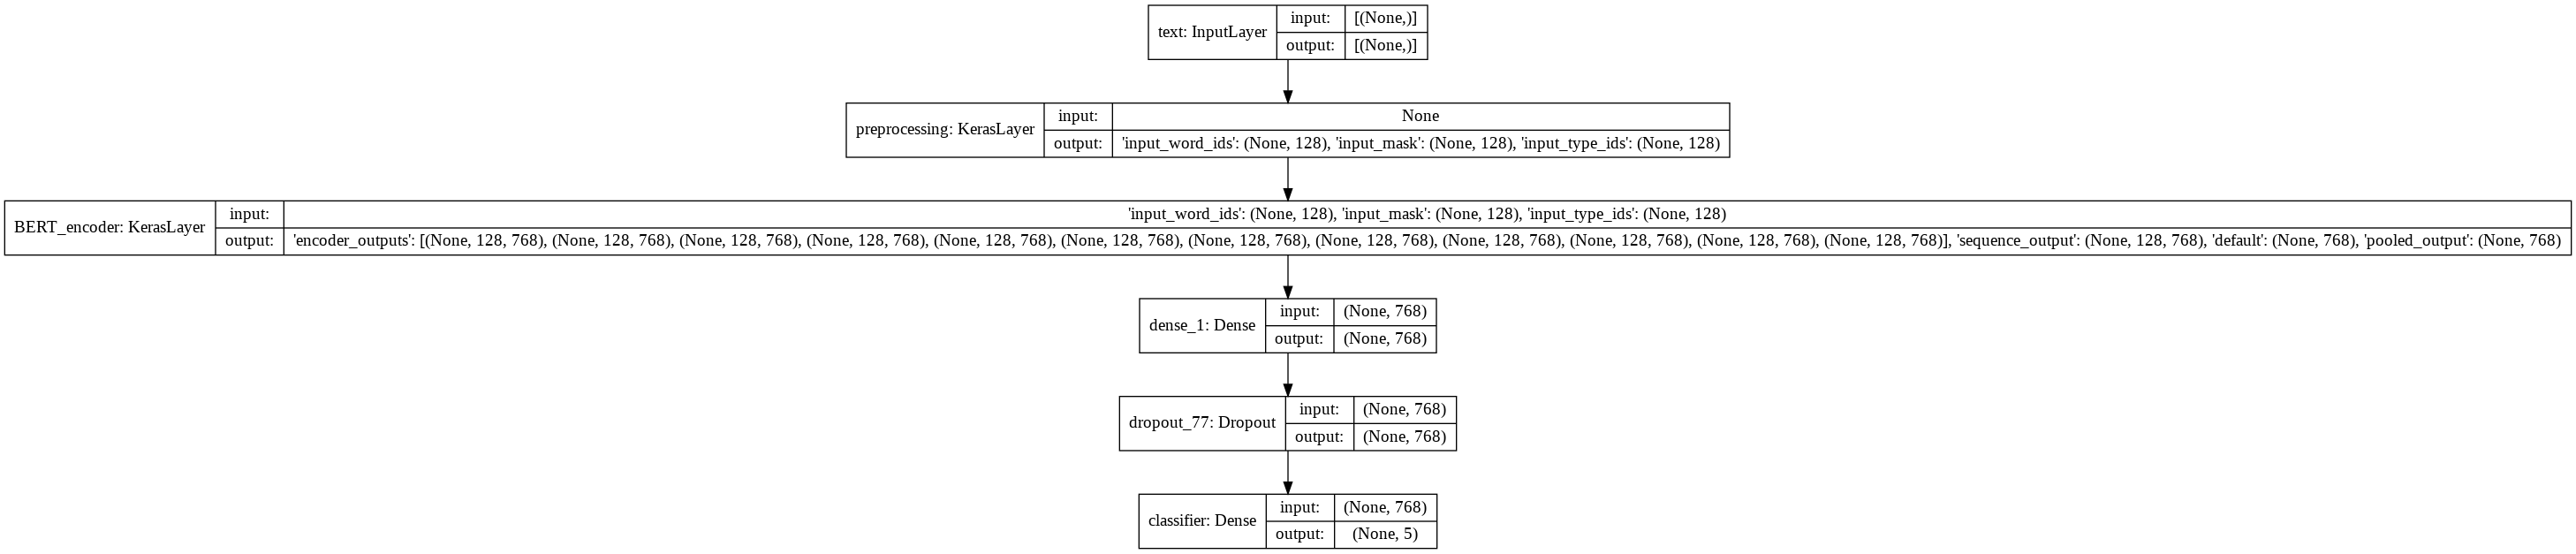

In [42]:
from keras.utils.vis_utils import plot_model
plot_model(ask_ubuntu_model, to_file='ask_ubuntu_model.png', show_shapes=True, show_layer_names=True)

In [43]:
print('Training baseline model AskUbuntu')
history_askubuntu = ask_ubuntu_model.fit(x = askubuntu_X_train, y = askubuntu_y_train,
                               validation_data=(askubuntu_X_val, askubuntu_y_val),
                               epochs=epochs)

Training baseline model AskUbuntu
Epoch 1/5
2/2 [==============================] - 15s 1s/step - loss: 1.6249 - accuracy: 0.3105 - val_loss: 2.3227 - val_accuracy: 0.4545
Epoch 2/5
2/2 [==============================] - 1s 414ms/step - loss: 2.5991 - accuracy: 0.2842 - val_loss: 2.5576 - val_accuracy: 0.1818
Epoch 3/5
2/2 [==============================] - 1s 425ms/step - loss: 3.0173 - accuracy: 0.1210 - val_loss: 1.6007 - val_accuracy: 0.4545
Epoch 4/5
2/2 [==============================] - 1s 427ms/step - loss: 1.8149 - accuracy: 0.3472 - val_loss: 2.5382 - val_accuracy: 0.2727
Epoch 5/5
2/2 [==============================] - 1s 420ms/step - loss: 2.1017 - accuracy: 0.2946 - val_loss: 1.6191 - val_accuracy: 0.1818


In [44]:
loss, accuracy = ask_ubuntu_model.evaluate(askubuntu_X_test, askubuntu_y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

4/4 [==============================] - 1s 253ms/step - loss: 1.4509 - accuracy: 0.3394
Loss: 1.4509340524673462
Accuracy: 0.33944955468177795


In [45]:
dataset_name = 'askubuntu_baseline'
saved_model_path = 'baselines/{}_bert'.format(dataset_name.replace('/', '_'))

ask_ubuntu_model.save(saved_model_path, include_optimizer=False)

## ChatBot

In [46]:
chatbot_model = build_classifier_model(chatbot_y_train)

loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
metrics = tf.metrics.BinaryAccuracy()

epochs = 5

chatbot_model.compile(optimizer="adam",
                         loss=loss,
                         metrics=metrics)

dict_keys(['encoder_outputs', 'sequence_output', 'default', 'pooled_output'])


In [47]:
chatbot_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_word_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'encoder_outputs':  109482241   preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
____________________________________________________________________________________________

In [48]:
print('Training baseline model Chatbot')
history_chatbot = chatbot_model.fit(x = chatbot_X_train, y = chatbot_y_train,
                               validation_data=(chatbot_X_val, chatbot_y_val),
                               epochs=epochs)

Training baseline model Chatbot
Epoch 1/5
3/3 [==============================] - 15s 1s/step - loss: 1.2695 - binary_accuracy: 0.5000 - val_loss: 0.8878 - val_binary_accuracy: 0.5000
Epoch 2/5
3/3 [==============================] - 2s 763ms/step - loss: 2.0129 - binary_accuracy: 0.5000 - val_loss: 0.8511 - val_binary_accuracy: 0.5000
Epoch 3/5
3/3 [==============================] - 2s 768ms/step - loss: 1.1907 - binary_accuracy: 0.5000 - val_loss: 1.3947 - val_binary_accuracy: 0.5000
Epoch 4/5
3/3 [==============================] - 2s 763ms/step - loss: 1.6787 - binary_accuracy: 0.5000 - val_loss: 0.6948 - val_binary_accuracy: 0.5000
Epoch 5/5
3/3 [==============================] - 2s 770ms/step - loss: 1.1509 - binary_accuracy: 0.5000 - val_loss: 0.6969 - val_binary_accuracy: 0.5000


In [49]:
loss, accuracy = chatbot_model.evaluate(chatbot_X_test, chatbot_y_test, batch_size=128)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

1/1 [==============================] - 1s 1s/step - loss: 0.6969 - binary_accuracy: 0.5000
Loss: 0.6968557238578796
Accuracy: 0.5


In [50]:
dataset_name = 'chatbot_baseline'
saved_model_path = 'baselines/{}_bert'.format(dataset_name.replace('/', '_'))

chatbot_model.save(saved_model_path, include_optimizer=False)

## WebApps

In [51]:
webapps_model = build_classifier_model(webapps_y_train)

#loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction="auto", name="sparse_categorical_crossentropy")
#metrics = tf.metrics.Accuracy()

epochs = 5

webapps_model.compile(optimizer="adam",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

dict_keys(['sequence_output', 'default', 'pooled_output', 'encoder_outputs'])


In [52]:
webapps_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_word_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'sequence_output':  109482241   preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
____________________________________________________________________________________________

In [53]:
print('Training baseline model WebApps')
history_webapps = webapps_model.fit(x = webapps_X_train, y = webapps_y_train,
                               validation_data=(webapps_X_val, webapps_y_val),
                               epochs=epochs)

Training baseline model WebApps
Epoch 1/5
1/1 [==============================] - 13s 13s/step - loss: 2.0832 - accuracy: 0.2083 - val_loss: 2.0086 - val_accuracy: 0.3333
Epoch 2/5
1/1 [==============================] - 1s 738ms/step - loss: 2.5212 - accuracy: 0.1667 - val_loss: 3.4514 - val_accuracy: 0.0000e+00
Epoch 3/5
1/1 [==============================] - 1s 739ms/step - loss: 2.7646 - accuracy: 0.1667 - val_loss: 1.6339 - val_accuracy: 0.0000e+00
Epoch 4/5
1/1 [==============================] - 1s 745ms/step - loss: 3.7577 - accuracy: 0.1250 - val_loss: 1.8687 - val_accuracy: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 1s 744ms/step - loss: 2.3388 - accuracy: 0.2917 - val_loss: 2.1039 - val_accuracy: 0.0000e+00


In [54]:
loss, accuracy = webapps_model.evaluate(webapps_X_test, webapps_y_test, batch_size=128)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

1/1 [==============================] - 1s 615ms/step - loss: 2.0031 - accuracy: 0.1695
Loss: 2.003124713897705
Accuracy: 0.16949152946472168


In [55]:
print(1e-2)

0.01


In [56]:
dataset_name = 'webapps_baseline'
saved_model_path = 'baselines/{}_bert'.format(dataset_name.replace('/', '_'))

webapps_model.save(saved_model_path, include_optimizer=False)

In [57]:
from keras.utils.vis_utils import plot_model

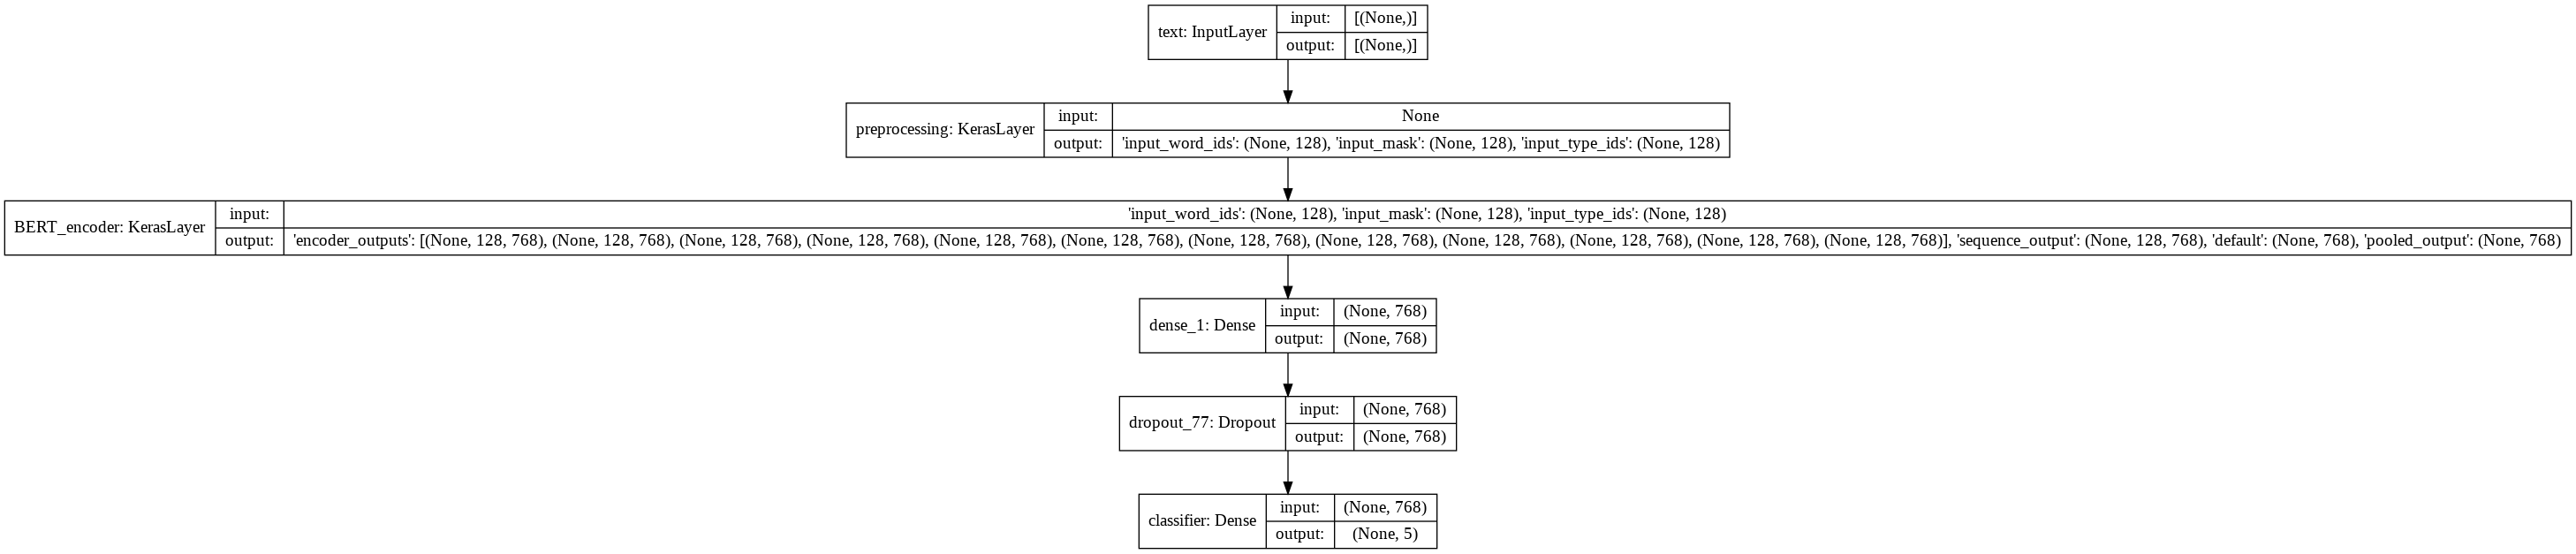

In [58]:
plot_model(ask_ubuntu_model, to_file='askubuntu_model.png', show_shapes=True, show_layer_names=True)

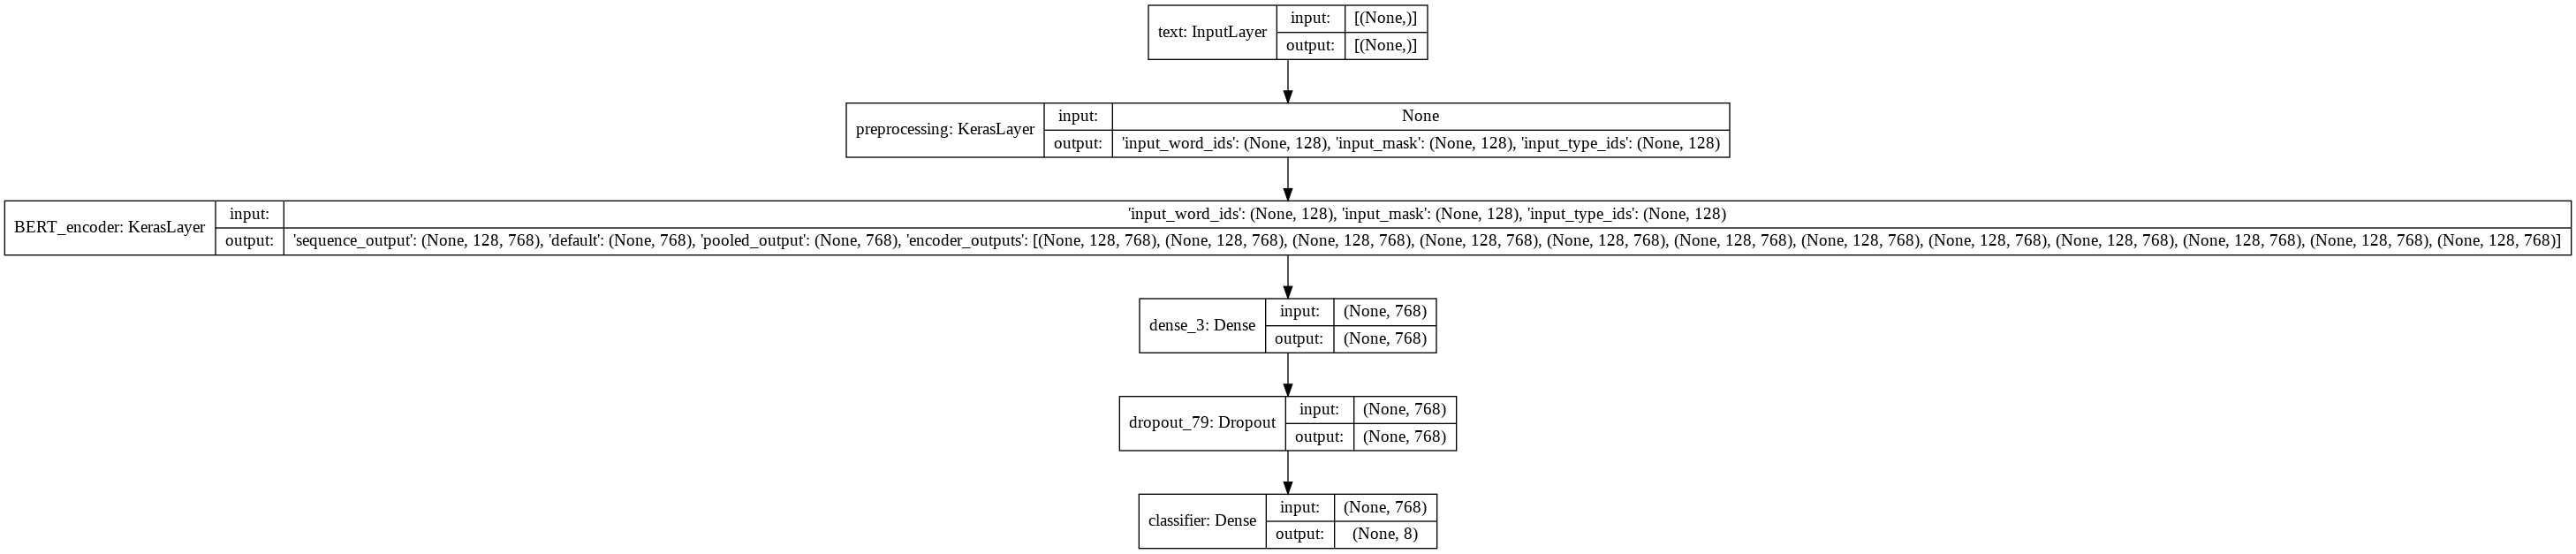

In [59]:
plot_model(webapps_model, to_file='webapps_model.png', show_shapes=True, show_layer_names=True)

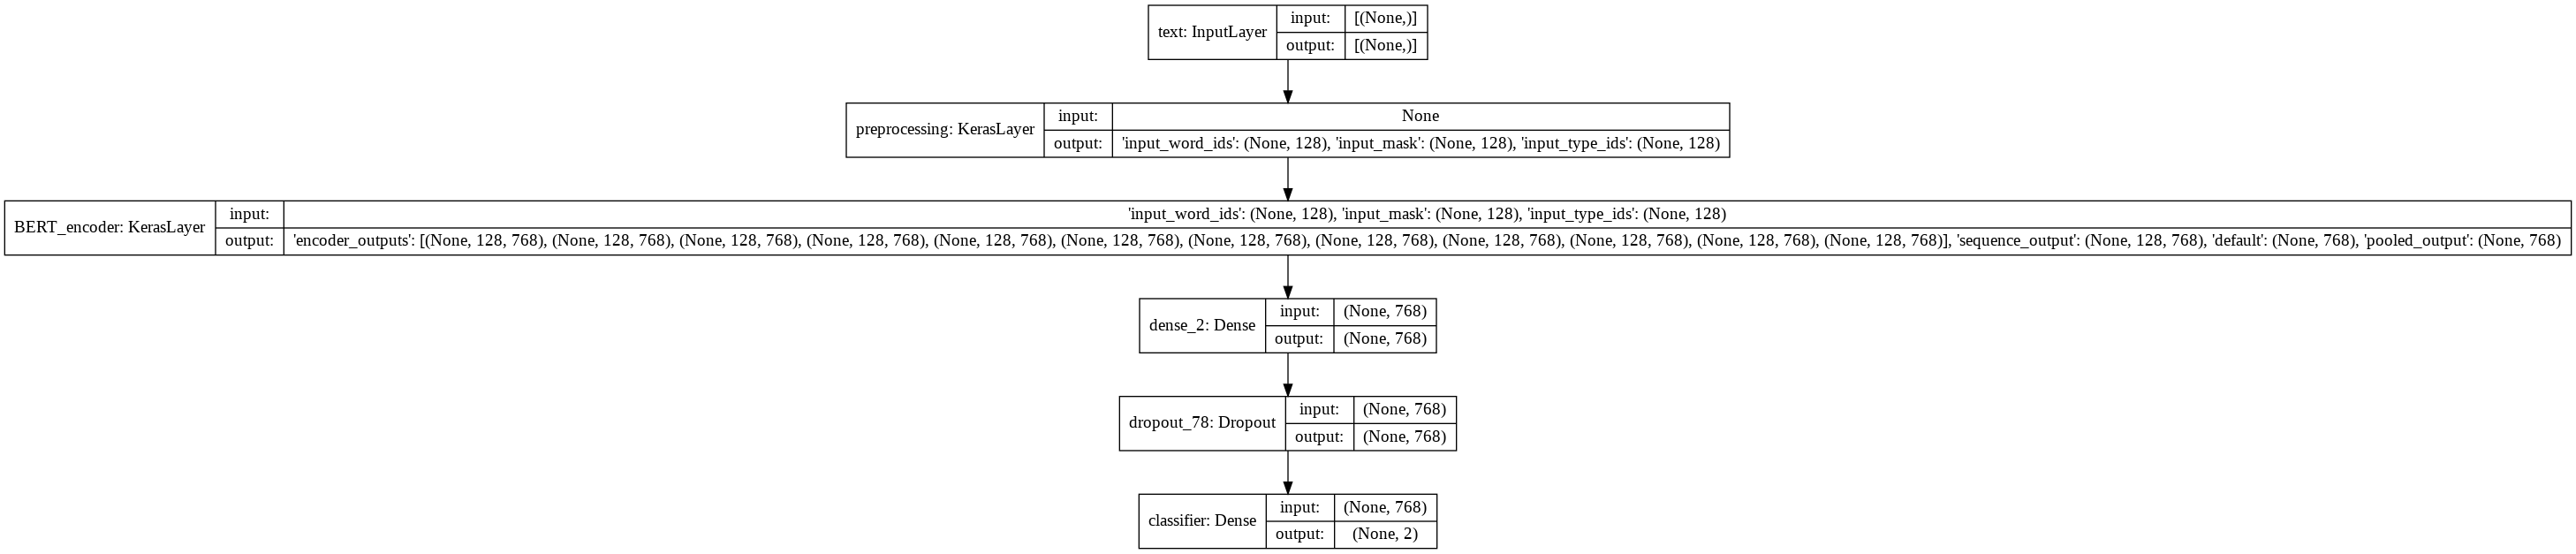

In [60]:
plot_model(chatbot_model, to_file='chatbot_model.png', show_shapes=True, show_layer_names=True)

In [61]:
_, train_acc = ask_ubuntu_model.evaluate(askubuntu_X_train, askubuntu_y_train)
_, test_acc = ask_ubuntu_model.evaluate(askubuntu_X_test, askubuntu_y_test)

print("train acc", train_acc)
print("test acc", test_acc)

4/4 [==============================] - 1s 251ms/step - loss: 1.4509 - accuracy: 0.3394
train acc 0.190476194024086
test acc 0.33944955468177795


In [62]:
_, train_acc = webapps_model.evaluate(webapps_X_train, webapps_y_train)
_, test_acc = webapps_model.evaluate(webapps_X_test, webapps_y_test)

print("train acc", train_acc)
print("test acc", test_acc)

2/2 [==============================] - 1s 266ms/step - loss: 2.0031 - accuracy: 0.1695
train acc 0.2916666567325592
test acc 0.16949152946472168


In [63]:
_, train_acc = chatbot_model.evaluate(chatbot_X_train, chatbot_y_train)
_, test_acc = chatbot_model.evaluate(chatbot_X_test, chatbot_y_test)

print("train acc", train_acc)
print("test acc", test_acc)

4/4 [==============================] - 1s 238ms/step - loss: 0.6969 - binary_accuracy: 0.5000
train acc 0.5
test acc 0.5
